In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Eksik verileri kontrol etme ve doldurma
data.replace('unknown', np.nan, inplace=True)
data.ffill(inplace=True)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)  # İkili sınıflandırma için y'yi 0 ve 1 olarak kodlayın

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal özellikleri normalleştirme
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


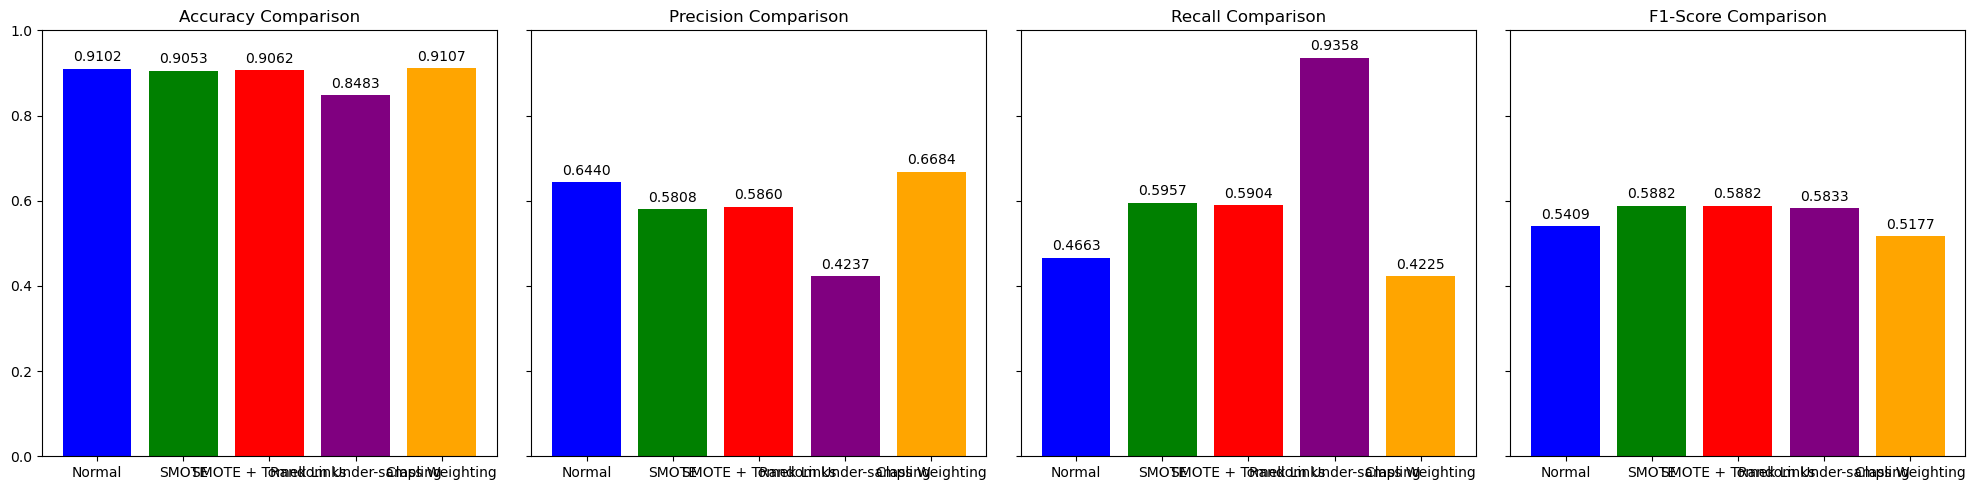

                  Method  Accuracy  Precision    Recall  F1-Score
0                 Normal  0.910172   0.644018  0.466310  0.540943
1                  SMOTE  0.905317   0.580813  0.595722  0.588173
2    SMOTE + Tomek Links  0.906167   0.585987  0.590374  0.588173
3  Random Under-sampling  0.848264   0.423729  0.935829  0.583333
4        Class Weighting  0.910658   0.668359  0.422460  0.517693


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Eksik verileri kontrol etme ve doldurma
data.replace('unknown', np.nan, inplace=True)
data.ffill(inplace=True)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)  # İkili sınıflandırma için y'yi 0 ve 1 olarak kodlayın

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline ile ön işleme adımları
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Normal Durum (Sınıf Dengesizliği Çözümü Yok)
model_normal = RandomForestClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

# 3. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
model_smote_tomek = RandomForestClassifier(random_state=42)
model_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)
y_pred_smote_tomek = model_smote_tomek.predict(X_test)

# 4. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

# 5. Class Weighting
class_weight = {0: 1, 1: len(y_train) / sum(y_train)}
model_class_weight = RandomForestClassifier(random_state=42, class_weight=class_weight)
model_class_weight.fit(X_train, y_train)
y_pred_class_weight = model_class_weight.predict(X_test)

# Performans Karşılaştırması
results = {
    'Method': ['Normal', 'SMOTE', 'SMOTE + Tomek Links', 'Random Under-sampling', 'Class Weighting'],
    'Accuracy': [accuracy_score(y_test, y_pred_normal), accuracy_score(y_test, y_pred_smote), accuracy_score(y_test, y_pred_smote_tomek), accuracy_score(y_test, y_pred_rus), accuracy_score(y_test, y_pred_class_weight)],
    'Precision': [precision_score(y_test, y_pred_normal), precision_score(y_test, y_pred_smote), precision_score(y_test, y_pred_smote_tomek), precision_score(y_test, y_pred_rus), precision_score(y_test, y_pred_class_weight)],
    'Recall': [recall_score(y_test, y_pred_normal), recall_score(y_test, y_pred_smote), recall_score(y_test, y_pred_smote_tomek), recall_score(y_test, y_pred_rus), recall_score(y_test, y_pred_class_weight)],
    'F1-Score': [f1_score(y_test, y_pred_normal), f1_score(y_test, y_pred_smote), f1_score(y_test, y_pred_smote_tomek), f1_score(y_test, y_pred_rus), f1_score(y_test, y_pred_class_weight)]
}

results_df = pd.DataFrame(results)

# Sonuçları Görselleştirme
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=['blue', 'green', 'red', 'purple', 'orange'])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylim(0, 1)
    for j, value in enumerate(results_df[metric]):
        axes[i].text(j, value + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sonuçları Tablo Olarak Gösterme
print(results_df)


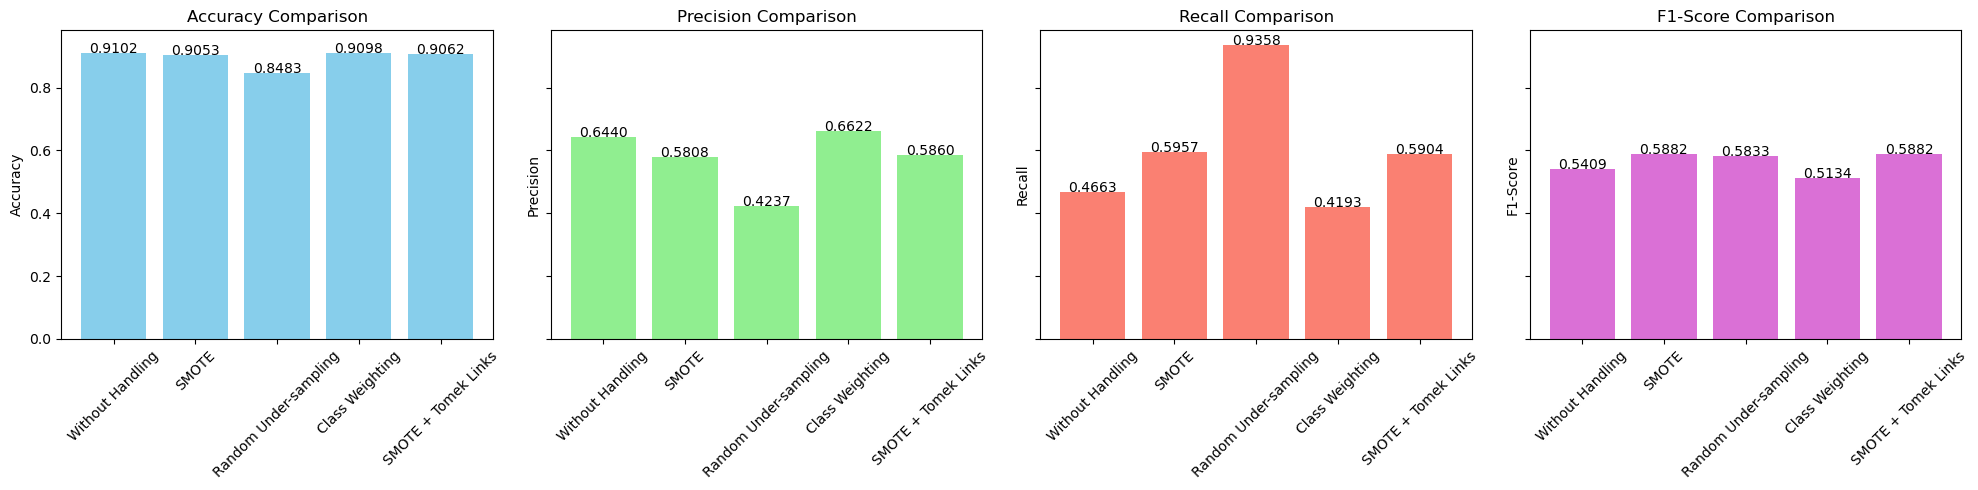

ModuleNotFoundError: No module named 'ace_tools'

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Eksik verileri kontrol etme ve doldurma
data.replace('unknown', np.nan, inplace=True)
data.ffill(inplace=True)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Normal Durum (Sınıf Dengesizliği Çözümü Yok)
model_normal = RandomForestClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

# Performans Metrikleri
accuracy_normal = accuracy_score(y_test, y_pred_normal)
precision_normal = precision_score(y_test, y_pred_normal)
recall_normal = recall_score(y_test, y_pred_normal)
f1_normal = f1_score(y_test, y_pred_normal)

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

# Performans Metrikleri
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

# 3. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

# Performans Metrikleri
accuracy_rus = accuracy_score(y_test, y_pred_rus)
precision_rus = precision_score(y_test, y_pred_rus)
recall_rus = recall_score(y_test, y_pred_rus)
f1_rus = f1_score(y_test, y_pred_rus)

# 4. Class Weighting
model_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)

# Performans Metrikleri
accuracy_cw = accuracy_score(y_test, y_pred_cw)
precision_cw = precision_score(y_test, y_pred_cw)
recall_cw = recall_score(y_test, y_pred_cw)
f1_cw = f1_score(y_test, y_pred_cw)

# 5. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = RandomForestClassifier(random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

# Performans Metrikleri
accuracy_st = accuracy_score(y_test, y_pred_st)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)

# Sonuçları Tablo Olarak Saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [precision_normal, precision_smote, precision_rus, precision_cw, precision_st],
    'Recall': [recall_normal, recall_smote, recall_rus, recall_cw, recall_st],
    'F1-Score': [f1_normal, f1_smote, f1_rus, f1_cw, f1_st]
})

# Performans Metriklerini Görselleştirme
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'gold']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=45)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Sonuçları Tablo Olarak Gösterme
import ace_tools as tools; tools.display_dataframe_to_user(name="Random Forest Performans Sonuçları", dataframe=results_df)


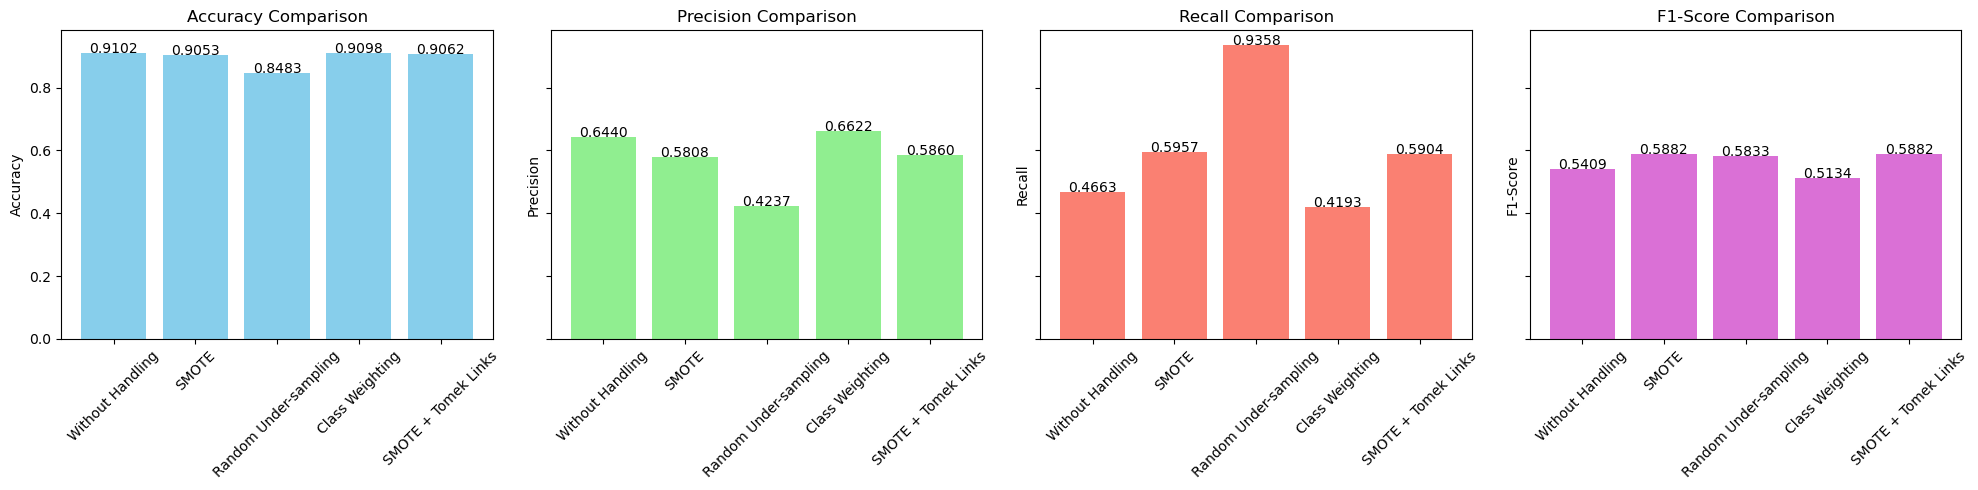

Random Forest Performans Sonuçları
                  Method  Accuracy  Precision    Recall  F1-Score
0       Without Handling  0.910172   0.644018  0.466310  0.540943
1                  SMOTE  0.905317   0.580813  0.595722  0.588173
2  Random Under-sampling  0.848264   0.423729  0.935829  0.583333
3        Class Weighting  0.909808   0.662162  0.419251  0.513425
4    SMOTE + Tomek Links  0.906167   0.585987  0.590374  0.588173


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Eksik verileri kontrol etme ve doldurma
data.replace('unknown', np.nan, inplace=True)
data.ffill(inplace=True)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Normal Durum (Sınıf Dengesizliği Çözümü Yok)
model_normal = RandomForestClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

# Performans Metrikleri
accuracy_normal = accuracy_score(y_test, y_pred_normal)
precision_normal = precision_score(y_test, y_pred_normal)
recall_normal = recall_score(y_test, y_pred_normal)
f1_normal = f1_score(y_test, y_pred_normal)

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

# Performans Metrikleri
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

# 3. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

# Performans Metrikleri
accuracy_rus = accuracy_score(y_test, y_pred_rus)
precision_rus = precision_score(y_test, y_pred_rus)
recall_rus = recall_score(y_test, y_pred_rus)
f1_rus = f1_score(y_test, y_pred_rus)

# 4. Class Weighting
model_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)

# Performans Metrikleri
accuracy_cw = accuracy_score(y_test, y_pred_cw)
precision_cw = precision_score(y_test, y_pred_cw)
recall_cw = recall_score(y_test, y_pred_cw)
f1_cw = f1_score(y_test, y_pred_cw)

# 5. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = RandomForestClassifier(random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

# Performans Metrikleri
accuracy_st = accuracy_score(y_test, y_pred_st)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)

# Sonuçları Tablo Olarak Saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [precision_normal, precision_smote, precision_rus, precision_cw, precision_st],
    'Recall': [recall_normal, recall_smote, recall_rus, recall_cw, recall_st],
    'F1-Score': [f1_normal, f1_smote, f1_rus, f1_cw, f1_st]
})

# Performans Metriklerini Görselleştirme
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'gold']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=45)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Sonuçları Tablo Olarak Gösterme
print("Random Forest Performans Sonuçları")
print(results_df)


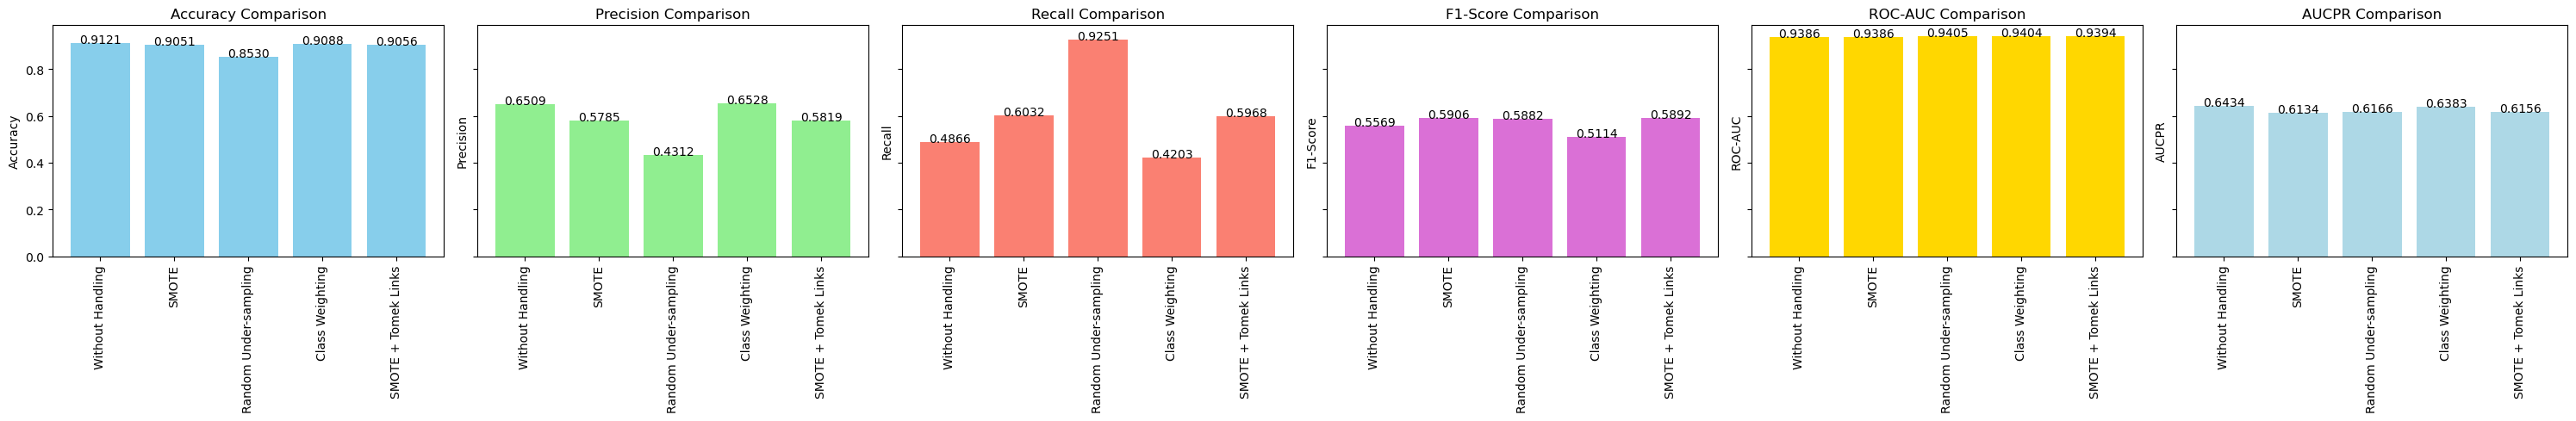

Random Forest Performans Sonuçları
                  Method  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0       Without Handling  0.912115   0.650930  0.486631  0.556916  0.938619   
1                  SMOTE  0.905074   0.578462  0.603209  0.590576  0.938633   
2  Random Under-sampling  0.852998   0.431206  0.925134  0.588235  0.940467   
3        Class Weighting  0.908837   0.652824  0.420321  0.511386  0.940442   
4    SMOTE + Tomek Links  0.905560   0.581856  0.596791  0.589229  0.939351   

      AUCPR  
0  0.643385  
1  0.613396  
2  0.616615  
3  0.638294  
4  0.615614  


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')



# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Normal Durum (Sınıf Dengesizliği Çözümü Yok)
model_normal = RandomForestClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)
y_proba_normal = model_normal.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_normal = accuracy_score(y_test, y_pred_normal)
precision_normal = precision_score(y_test, y_pred_normal)
recall_normal = recall_score(y_test, y_pred_normal)
f1_normal = f1_score(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_proba_normal)
aucpr_normal = average_precision_score(y_test, y_proba_normal)

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)
aucpr_smote = average_precision_score(y_test, y_proba_smote)

# 3. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)
y_proba_rus = model_rus.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_rus = accuracy_score(y_test, y_pred_rus)
precision_rus = precision_score(y_test, y_pred_rus)
recall_rus = recall_score(y_test, y_pred_rus)
f1_rus = f1_score(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_proba_rus)
aucpr_rus = average_precision_score(y_test, y_proba_rus)

# 4. Class Weighting
model_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)
y_proba_cw = model_cw.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_cw = accuracy_score(y_test, y_pred_cw)
precision_cw = precision_score(y_test, y_pred_cw)
recall_cw = recall_score(y_test, y_pred_cw)
f1_cw = f1_score(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_proba_cw)
aucpr_cw = average_precision_score(y_test, y_proba_cw)

# 5. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = RandomForestClassifier(random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)
y_proba_st = model_st.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_st = accuracy_score(y_test, y_pred_st)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_proba_st)
aucpr_st = average_precision_score(y_test, y_proba_st)

# Sonuçları Tablo Olarak Saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [precision_normal, precision_smote, precision_rus, precision_cw, precision_st],
    'Recall': [recall_normal, recall_smote, recall_rus, recall_cw, recall_st],
    'F1-Score': [f1_normal, f1_smote, f1_rus, f1_cw, f1_st],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Performans Metriklerini Görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(30, 5), sharey=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'gold', 'lightblue']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=90)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Sonuçları Tablo Olarak Gösterme
print("Random Forest Performans Sonuçları")
print(results_df)


                  Method  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0       Without Handling  0.910172   0.644018  0.466310  0.540943  0.939230   
1                  SMOTE  0.905317   0.580813  0.595722  0.588173  0.939445   
2  Random Under-sampling  0.848264   0.423729  0.935829  0.583333  0.939622   
3        Class Weighting  0.909808   0.662162  0.419251  0.513425  0.940366   
4    SMOTE + Tomek Links  0.906167   0.585987  0.590374  0.588173  0.939405   

      AUCPR  
0  0.641549  
1  0.616036  
2  0.608702  
3  0.636806  
4  0.616932  


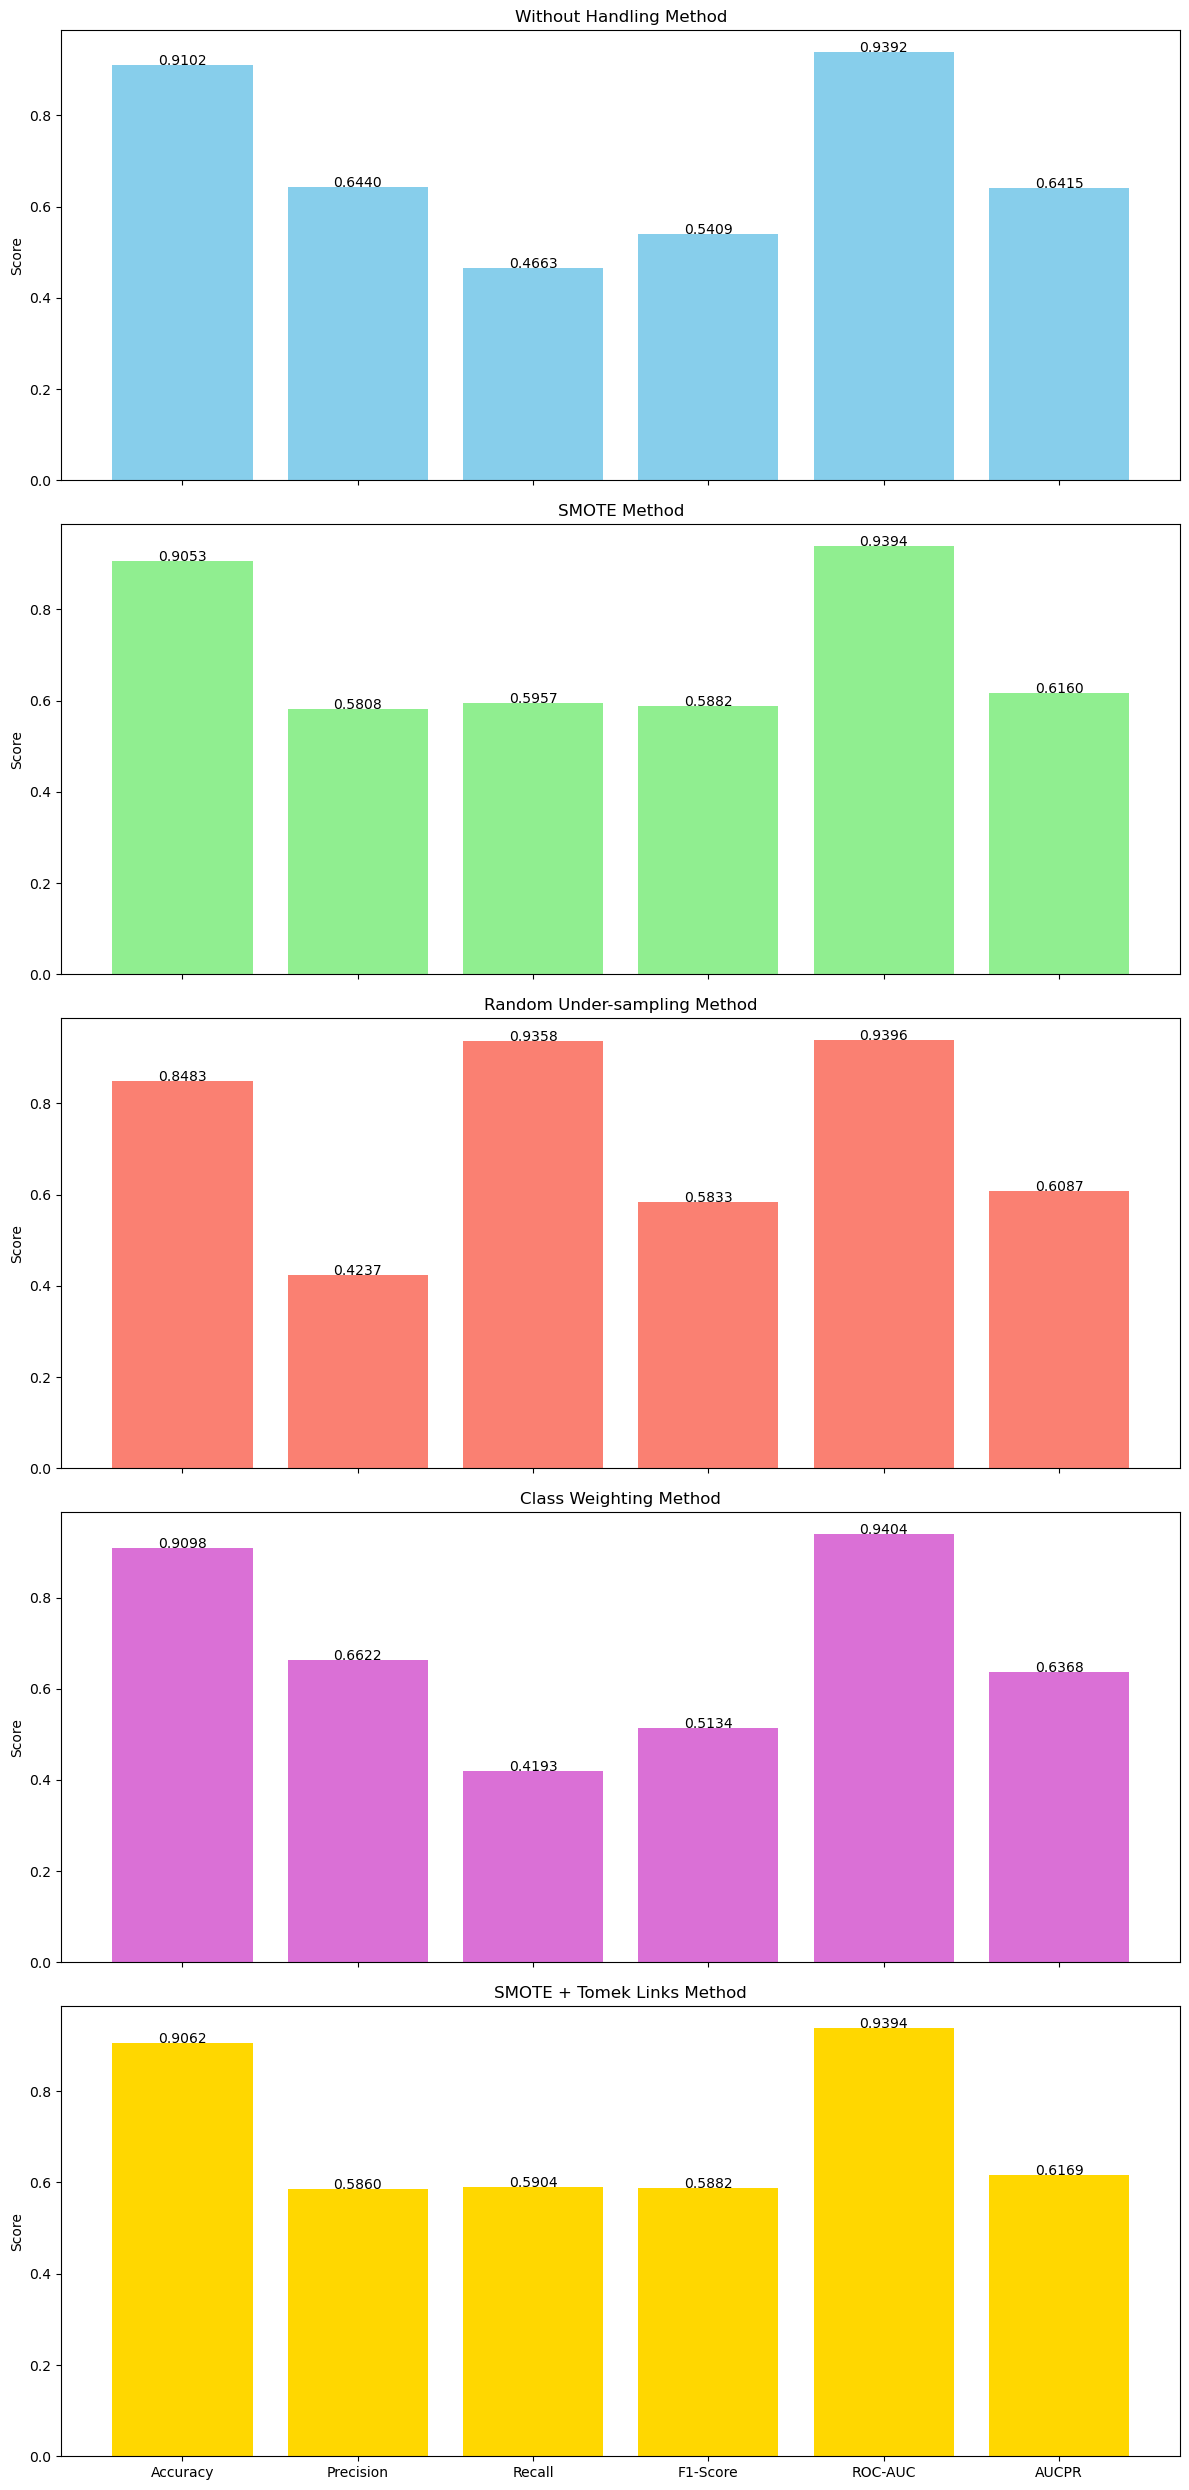

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Eksik verileri kontrol etme ve doldurma
data.replace('unknown', np.nan, inplace=True)
data.ffill(inplace=True)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Normal Durum (Sınıf Dengesizliği Çözümü Yok)
model_normal = RandomForestClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)
y_proba_normal = model_normal.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_normal = accuracy_score(y_test, y_pred_normal)
precision_normal = precision_score(y_test, y_pred_normal)
recall_normal = recall_score(y_test, y_pred_normal)
f1_normal = f1_score(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_proba_normal)
aucpr_normal = average_precision_score(y_test, y_proba_normal)

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)
aucpr_smote = average_precision_score(y_test, y_proba_smote)

# 3. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)
y_proba_rus = model_rus.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_rus = accuracy_score(y_test, y_pred_rus)
precision_rus = precision_score(y_test, y_pred_rus)
recall_rus = recall_score(y_test, y_pred_rus)
f1_rus = f1_score(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_proba_rus)
aucpr_rus = average_precision_score(y_test, y_proba_rus)

# 4. Class Weighting
model_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)
y_proba_cw = model_cw.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_cw = accuracy_score(y_test, y_pred_cw)
precision_cw = precision_score(y_test, y_pred_cw)
recall_cw = recall_score(y_test, y_pred_cw)
f1_cw = f1_score(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_proba_cw)
aucpr_cw = average_precision_score(y_test, y_proba_cw)

# 5. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = RandomForestClassifier(random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)
y_proba_st = model_st.predict_proba(X_test)[:, 1]

# Performans Metrikleri
accuracy_st = accuracy_score(y_test, y_pred_st)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_proba_st)
aucpr_st = average_precision_score(y_test, y_proba_st)

# Sonuçları Tablo Olarak Saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [precision_normal, precision_smote, precision_rus, precision_cw, precision_st],
    'Recall': [recall_normal, recall_smote, recall_rus, recall_cw, recall_st],
    'F1-Score': [f1_normal, f1_smote, f1_rus, f1_cw, f1_st],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Sonuçları Tablo Olarak Yazdırma
print(results_df)

# Performans Metriklerini Görselleştirme
fig, axes = plt.subplots(5, 1, figsize=(12, 25), sharex=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
methods = ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'gold']

for i, method in enumerate(methods):
    axes[i].bar(metrics, results_df.iloc[i, 1:], color=colors[i])
    axes[i].set_title(f'{method} Method')
    axes[i].set_ylabel('Score')
    for j, metric in enumerate(metrics):
        axes[i].text(j, results_df.iloc[i, j+1], f"{results_df.iloc[i, j+1]:.4f}", ha='center')

plt.tight_layout()
plt.show()


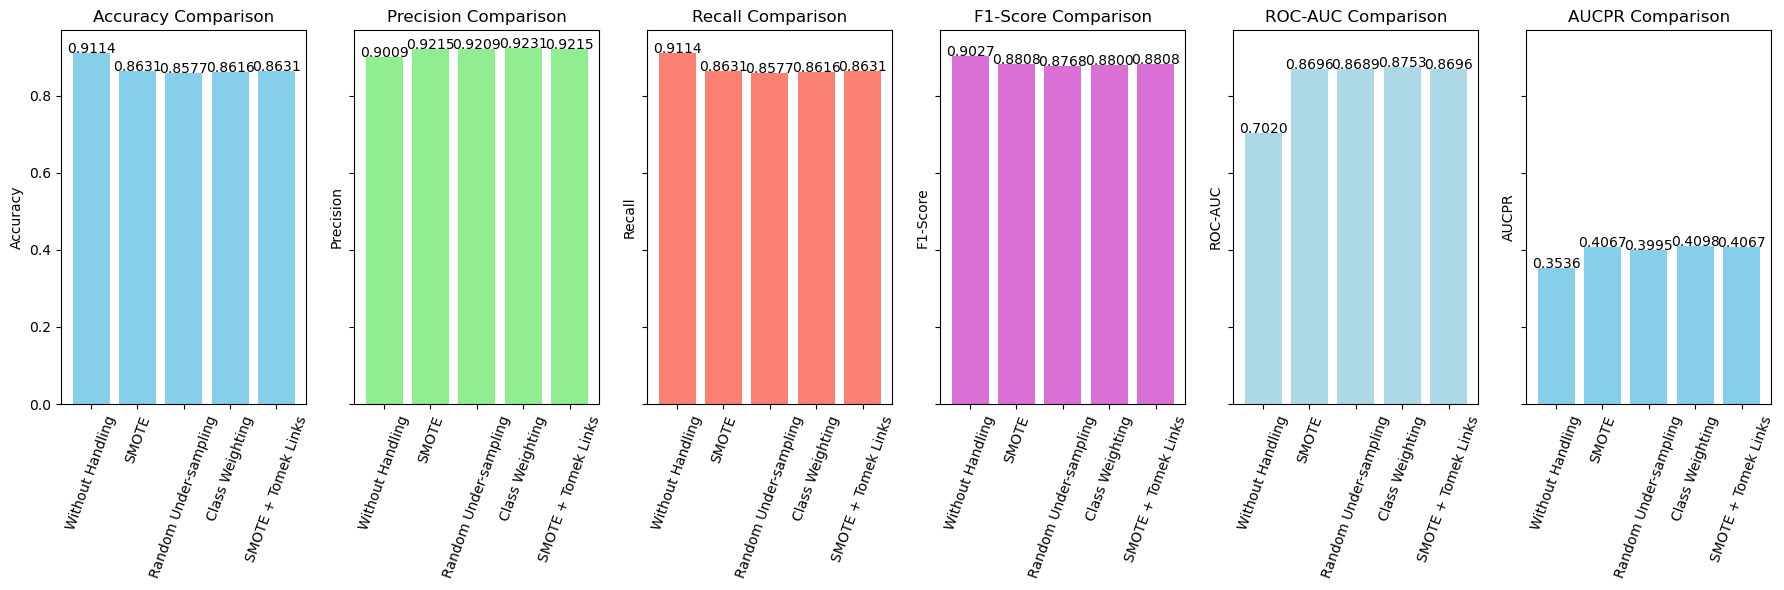

,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.911386,0.900853,0.911386,0.902742,0.701952,0.353596
1,SMOTE,0.863074,0.921499,0.863074,0.880822,0.869614,0.406699
2,Random Under-sampling,0.857732,0.920911,0.857732,0.876792,0.868933,0.399524
3,Class Weighting,0.861617,0.923114,0.861617,0.880004,0.875320,0.409843
4,SMOTE + Tomek Links,0.863074,0.921499,0.863074,0.880822,0.869614,0.406699


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_smote)
aucpr_smote = average_precision_score(y_test, y_pred_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = LogisticRegression(max_iter=1000, random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_pred_rus)
aucpr_rus = average_precision_score(y_test, y_pred_rus)

# 3. Class Weighting
model_cw = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)

report_cw = classification_report(y_test, y_pred_cw)
accuracy_cw = accuracy_score(y_test, y_pred_cw)
conf_matrix_cw = confusion_matrix(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_pred_cw)
aucpr_cw = average_precision_score(y_test, y_pred_cw)

# 4. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = LogisticRegression(max_iter=1000, random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_pred_st)
aucpr_st = average_precision_score(y_test, y_pred_st)

# 5. Without Handling
model_normal = LogisticRegression(max_iter=1000, random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_pred_normal)
aucpr_normal = average_precision_score(y_test, y_pred_normal)

(results_smote, results_rus, results_cw, results_st, results_normal) = (
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_cw, accuracy_cw, conf_matrix_cw, roc_auc_cw, aucpr_cw),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st),
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal)
)

# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Performans metriklerini görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=70)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

results_df


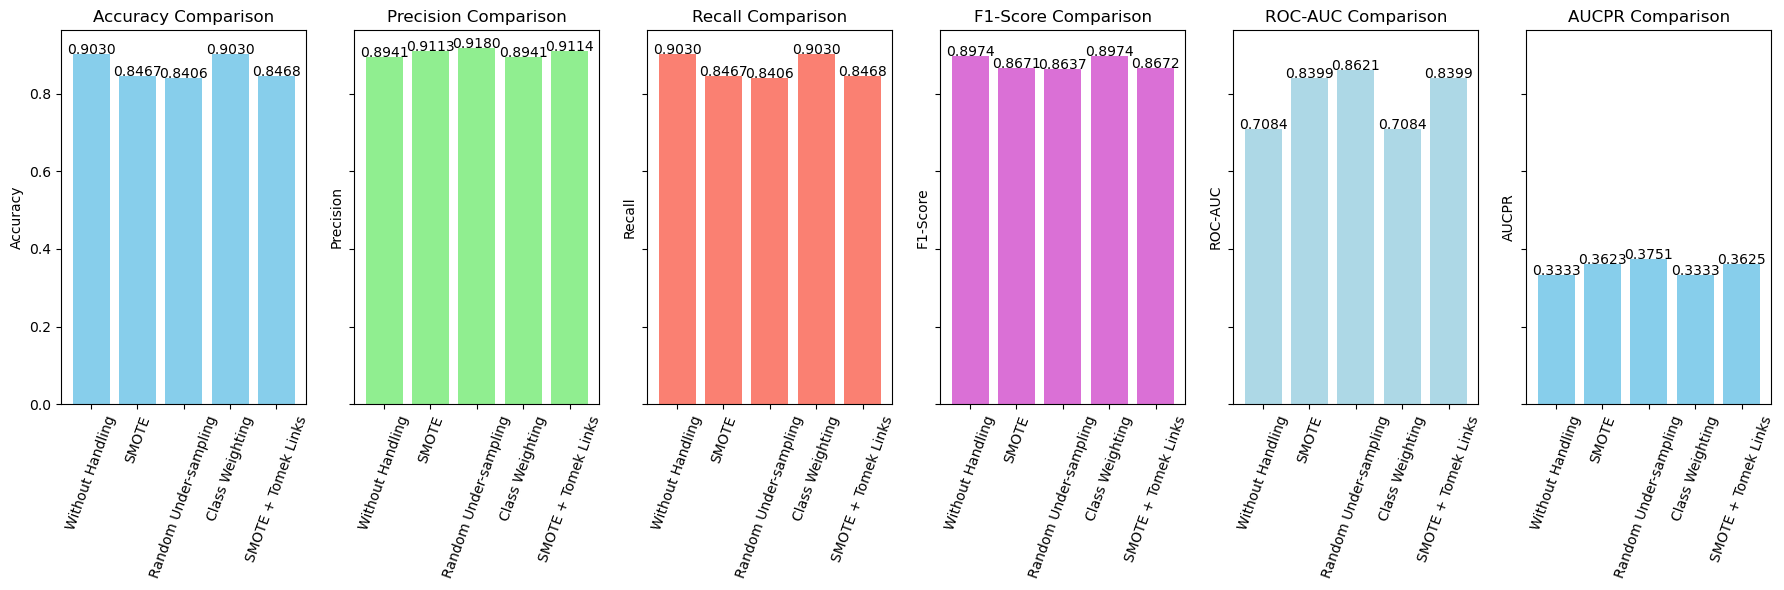

,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.903010,0.894114,0.903010,0.897354,0.708419,0.333259
1,SMOTE,0.846686,0.911323,0.846686,0.867141,0.839854,0.362272
2,Random Under-sampling,0.840617,0.918009,0.840617,0.863715,0.862077,0.375063
3,Class Weighting,0.903010,0.894114,0.903010,0.897354,0.708419,0.333259
4,SMOTE + Tomek Links,0.846807,0.911352,0.846807,0.867234,0.839923,0.362454


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = KNeighborsClassifier()
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_smote)
aucpr_smote = average_precision_score(y_test, y_pred_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = KNeighborsClassifier()
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_pred_rus)
aucpr_rus = average_precision_score(y_test, y_pred_rus)

# 3. Class Weighting
model_cw = KNeighborsClassifier()
# Class weighting is not applicable for KNN directly.
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)

report_cw = classification_report(y_test, y_pred_cw)
accuracy_cw = accuracy_score(y_test, y_pred_cw)
conf_matrix_cw = confusion_matrix(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_pred_cw)
aucpr_cw = average_precision_score(y_test, y_pred_cw)

# 4. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = KNeighborsClassifier()
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_pred_st)
aucpr_st = average_precision_score(y_test, y_pred_st)

# 5. Without Handling
model_normal = KNeighborsClassifier()
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_pred_normal)
aucpr_normal = average_precision_score(y_test, y_pred_normal)

(results_smote, results_rus, results_cw, results_st, results_normal) = (
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_cw, accuracy_cw, conf_matrix_cw, roc_auc_cw, aucpr_cw),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st),
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal)
)

# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Performans metriklerini görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=70)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

results_df


En iyi K değeri: 25


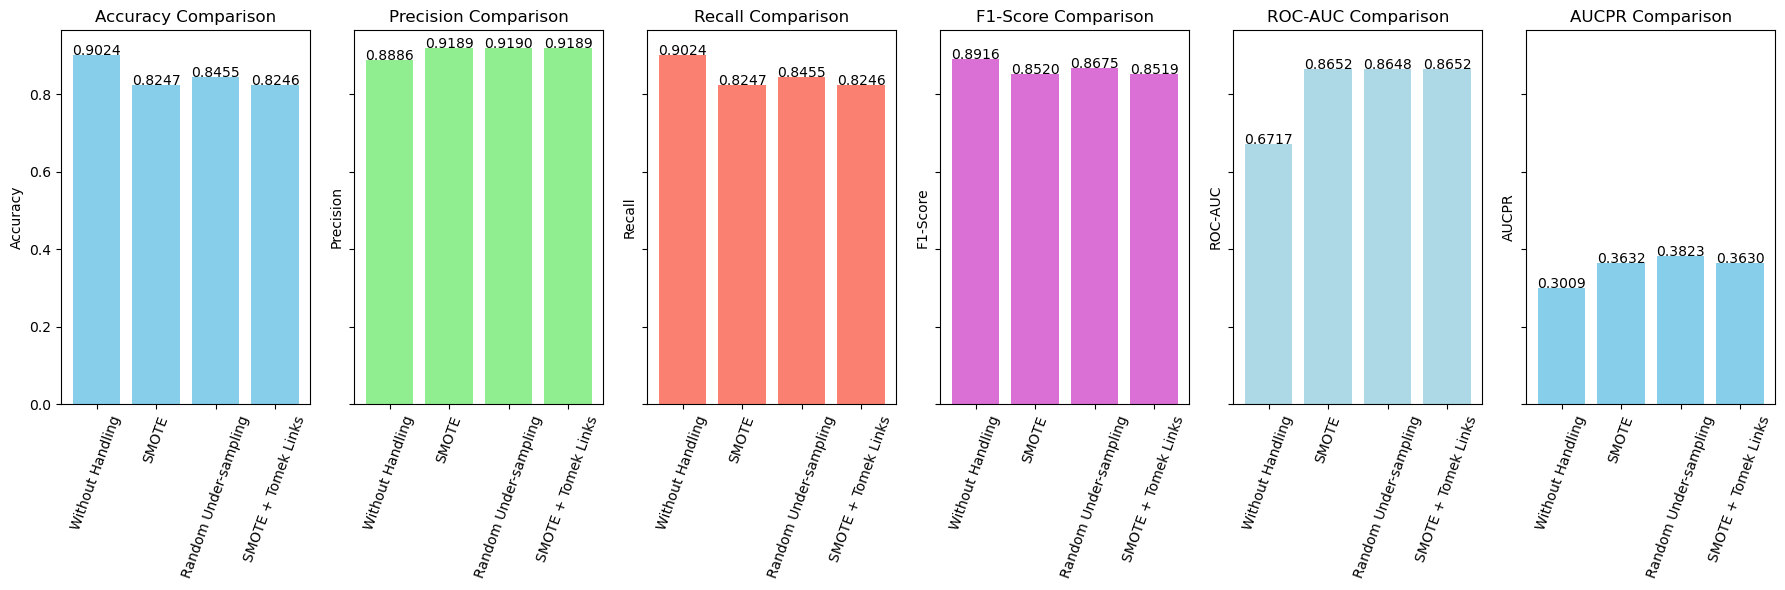

,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.902403,0.888641,0.902403,0.891647,0.671706,0.300884
1,SMOTE,0.824715,0.918916,0.824715,0.852002,0.865232,0.363208
2,Random Under-sampling,0.845472,0.919027,0.845472,0.867453,0.864816,0.382306
3,SMOTE + Tomek Links,0.824593,0.918895,0.824593,0.851909,0.865163,0.363049


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# KNN için en iyi K değerini bulma
param_grid = {'n_neighbors': range(1, 31)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"En iyi K değeri: {best_k}")

# KNN modelini en iyi K değeriyle eğitme
model_knn = KNeighborsClassifier(n_neighbors=best_k)

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = KNeighborsClassifier(n_neighbors=best_k)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_smote)
aucpr_smote = average_precision_score(y_test, y_pred_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = KNeighborsClassifier(n_neighbors=best_k)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_pred_rus)
aucpr_rus = average_precision_score(y_test, y_pred_rus)

# 3. Class Weighting (Not applicable directly for KNN)

# 4. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = KNeighborsClassifier(n_neighbors=best_k)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_pred_st)
aucpr_st = average_precision_score(y_test, y_pred_st)

# 5. Without Handling
model_normal = KNeighborsClassifier(n_neighbors=best_k)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_pred_normal)
aucpr_normal = average_precision_score(y_test, y_pred_normal)

(results_smote, results_rus, results_st, results_normal) = (
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st),
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal)
)

# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_st]
})

# Performans metriklerini görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=70)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

results_df


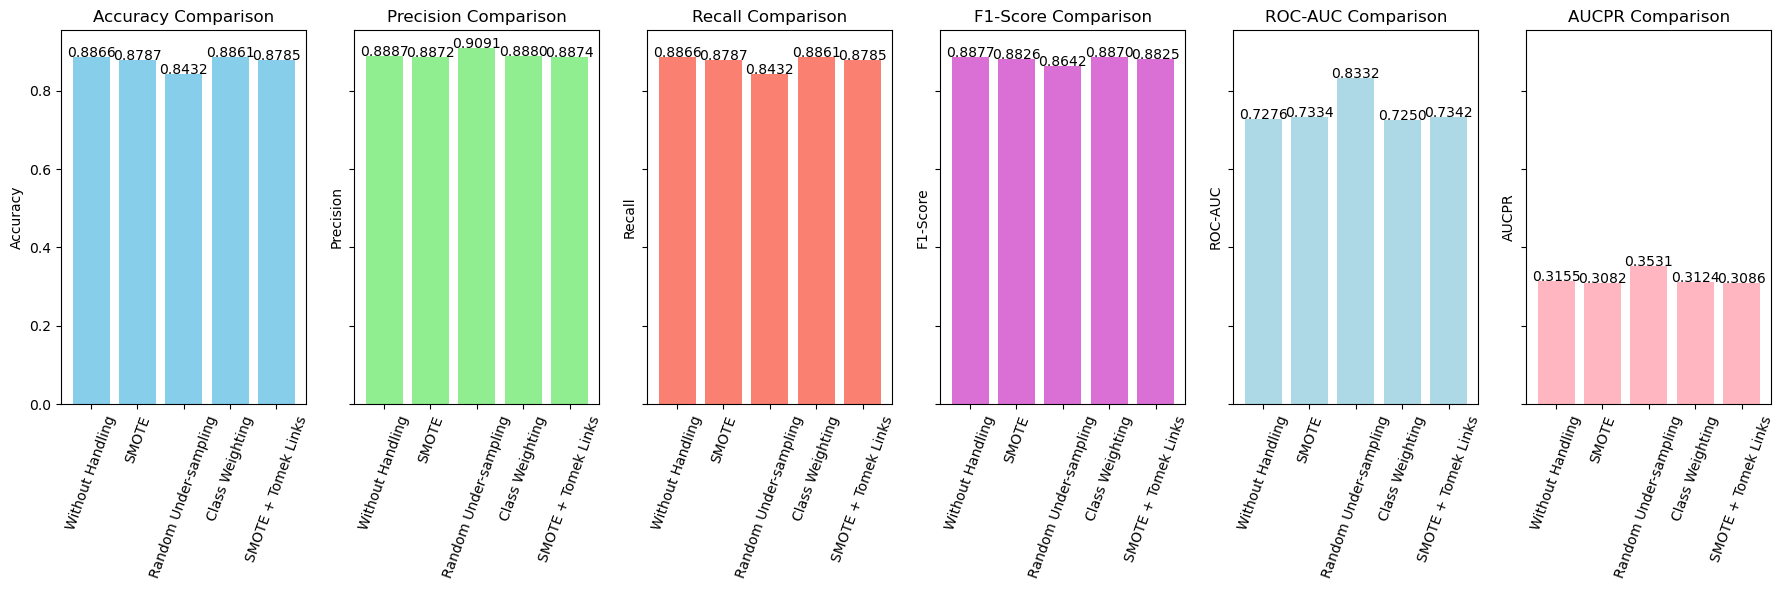

,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.886623,0.888749,0.886623,0.887654,0.727620,0.315491
1,SMOTE,0.878733,0.887236,0.878733,0.882582,0.733428,0.308215
2,Random Under-sampling,0.843166,0.909072,0.843166,0.864201,0.833206,0.353120
3,Class Weighting,0.886137,0.887951,0.886137,0.887021,0.725015,0.312357
4,SMOTE + Tomek Links,0.878490,0.887354,0.878490,0.882489,0.734224,0.308566


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = DecisionTreeClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_smote)
aucpr_smote = average_precision_score(y_test, y_pred_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = DecisionTreeClassifier(random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_pred_rus)
aucpr_rus = average_precision_score(y_test, y_pred_rus)

# 3. Class Weighting
model_cw = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)

report_cw = classification_report(y_test, y_pred_cw)
accuracy_cw = accuracy_score(y_test, y_pred_cw)
conf_matrix_cw = confusion_matrix(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_pred_cw)
aucpr_cw = average_precision_score(y_test, y_pred_cw)

# 4. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = DecisionTreeClassifier(random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_pred_st)
aucpr_st = average_precision_score(y_test, y_pred_st)

# 5. Without Handling
model_normal = DecisionTreeClassifier(random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_pred_normal)
aucpr_normal = average_precision_score(y_test, y_pred_normal)

(results_normal, results_smote, results_rus, results_cw, results_st) = (
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal),
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_cw, accuracy_cw, conf_matrix_cw, roc_auc_cw, aucpr_cw),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st)
)

# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Performans metriklerini görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue', 'lightpink']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=70)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

results_df


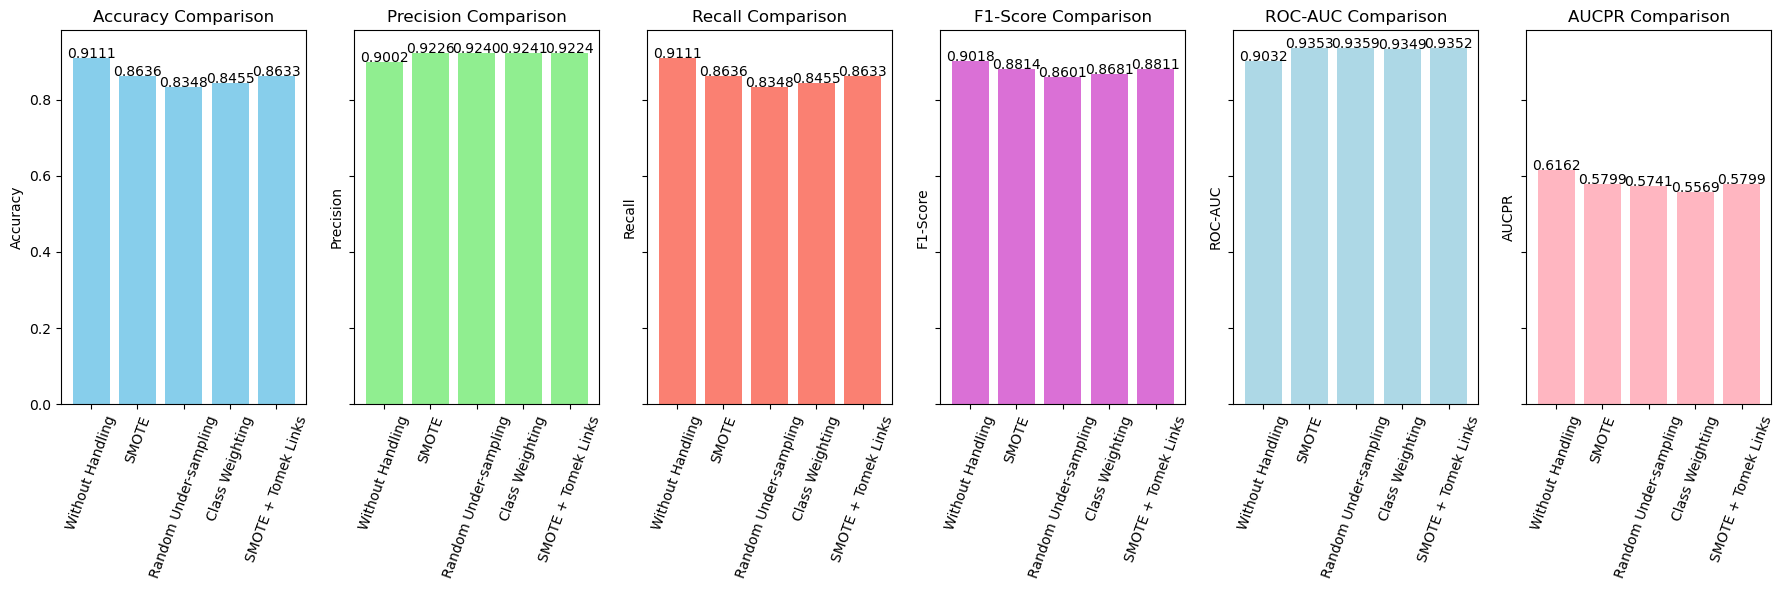

,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.911143,0.900212,0.911143,0.901820,0.903183,0.616238
1,SMOTE,0.863559,0.922600,0.863559,0.881358,0.935256,0.579944
2,Random Under-sampling,0.834790,0.923981,0.834790,0.860145,0.935946,0.574074
3,Class Weighting,0.845472,0.924067,0.845472,0.868145,0.934877,0.556907
4,SMOTE + Tomek Links,0.863316,0.922400,0.863316,0.881146,0.935242,0.579874


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Veri setinin bir kısmını seçme (örneğin %10'u)
data_sample = data.sample(frac=0.1, random_state=42)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data_sample.drop(columns=['y'])
y = data_sample['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = SVC(kernel='rbf', probability=True, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_prob_smote)
aucpr_smote = average_precision_score(y_test, y_prob_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = SVC(kernel='rbf', probability=True, random_state=42)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)
y_prob_rus = model_rus.predict_proba(X_test)[:, 1]

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_prob_rus)
aucpr_rus = average_precision_score(y_test, y_prob_rus)

# 3. Class Weighting
model_cw = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
model_cw.fit(X_train, y_train)
y_pred_cw = model_cw.predict(X_test)
y_prob_cw = model_cw.predict_proba(X_test)[:, 1]

report_cw = classification_report(y_test, y_pred_cw)
accuracy_cw = accuracy_score(y_test, y_pred_cw)
conf_matrix_cw = confusion_matrix(y_test, y_pred_cw)
roc_auc_cw = roc_auc_score(y_test, y_prob_cw)
aucpr_cw = average_precision_score(y_test, y_prob_cw)

# 4. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = SVC(kernel='rbf', probability=True, random_state=42)
model_st.fit(X_train_st, y_train_st)
y_pred_st = model_st.predict(X_test)
y_prob_st = model_st.predict_proba(X_test)[:, 1]

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_prob_st)
aucpr_st = average_precision_score(y_test, y_prob_st)

# 5. Without Handling
model_normal = SVC(kernel='rbf', probability=True, random_state=42)
model_normal.fit(X_train, y_train)
y_pred_normal = model_normal.predict(X_test)
y_prob_normal = model_normal.predict_proba(X_test)[:, 1]

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_prob_normal)
aucpr_normal = average_precision_score(y_test, y_prob_normal)

(results_normal, results_smote, results_rus, results_cw, results_st) = (
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal),
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_cw, accuracy_cw, conf_matrix_cw, roc_auc_cw, aucpr_cw),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st)
)


# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'Class Weighting', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_cw, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_cw, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_cw, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_cw, aucpr_st]
})

# Performans metriklerini görselleştirme
fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUCPR']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue', 'lightpink']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(np.arange(len(results_df['Method'])))
    axes[i].set_xticklabels(results_df['Method'], rotation=70)
    for j in range(len(results_df)):
        axes[i].text(j, results_df[metric][j], f"{results_df[metric][j]:.4f}", ha='center')

plt.tight_layout()
plt.show()

results_df


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Veriyi yükle
data = pd.read_csv('bank-additional-full.csv', sep=';')

# Veri setinin bir kısmını seçme (örneğin %10'u)
data_sample = data.sample(frac=1, random_state=42)

# Hedef değişkeni (y) ve bağımsız değişkenleri (X) ayırma
X = data_sample.drop(columns=['y'])
y = data_sample['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Sayısal ve kategorik özellikleri belirleme
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Sayısal ve kategorik özellikler için transformerlar
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Kolon transformerı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline oluşturma
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Veriyi ön işleme tabi tutma
X_processed = pipeline.fit_transform(X)

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# ANN modeli oluşturma işlevi
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = create_ann_model(X_train_smote.shape[1])
model_smote.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, verbose=0)
y_pred_smote = (model_smote.predict(X_test) > 0.5).astype("int32")
y_prob_smote = model_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_prob_smote)
aucpr_smote = average_precision_score(y_test, y_prob_smote)

# 2. Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_rus = create_ann_model(X_train_rus.shape[1])
model_rus.fit(X_train_rus, y_train_rus, epochs=50, batch_size=32, verbose=0)
y_pred_rus = (model_rus.predict(X_test) > 0.5).astype("int32")
y_prob_rus = model_rus.predict(X_test)

report_rus = classification_report(y_test, y_pred_rus)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
roc_auc_rus = roc_auc_score(y_test, y_prob_rus)
aucpr_rus = average_precision_score(y_test, y_prob_rus)

# 3. SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)

model_st = create_ann_model(X_train_st.shape[1])
model_st.fit(X_train_st, y_train_st, epochs=50, batch_size=32, verbose=0)
y_pred_st = (model_st.predict(X_test) > 0.5).astype("int32")
y_prob_st = model_st.predict(X_test)

report_st = classification_report(y_test, y_pred_st)
accuracy_st = accuracy_score(y_test, y_pred_st)
conf_matrix_st = confusion_matrix(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_prob_st)
aucpr_st = average_precision_score(y_test, y_prob_st)

# 4. Without Handling
model_normal = create_ann_model(X_train.shape[1])
model_normal.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_normal = (model_normal.predict(X_test) > 0.5).astype("int32")
y_prob_normal = model_normal.predict(X_test)

report_normal = classification_report(y_test, y_pred_normal)
accuracy_normal = accuracy_score(y_test, y_pred_normal)
conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
roc_auc_normal = roc_auc_score(y_test, y_prob_normal)
aucpr_normal = average_precision_score(y_test, y_prob_normal)

(results_normal, results_smote, results_rus, results_st) = (
    (report_normal, accuracy_normal, conf_matrix_normal, roc_auc_normal, aucpr_normal),
    (report_smote, accuracy_smote, conf_matrix_smote, roc_auc_smote, aucpr_smote),
    (report_rus, accuracy_rus, conf_matrix_rus, roc_auc_rus, aucpr_rus),
    (report_st, accuracy_st, conf_matrix_st, roc_auc_st, aucpr_st)
)

# Performans metriklerini bir DataFrame olarak saklama
results_df = pd.DataFrame({
    'Method': ['Without Handling', 'SMOTE', 'Random Under-sampling', 'SMOTE + Tomek Links'],
    'Accuracy': [accuracy_normal, accuracy_smote, accuracy_rus, accuracy_st],
    'Precision': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_normal, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_st, output_dict=True)['weighted avg']['f1-score']
    ],
    'ROC-AUC': [roc_auc_normal, roc_auc_smote, roc_auc_rus, roc_auc_st],
    'AUCPR': [aucpr_normal, aucpr_smote, aucpr_rus, aucpr_st]
})

results_df

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Method,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUCPR
0,Without Handling,0.899005,0.896287,0.899005,0.897570,0.921876,0.551419
1,SMOTE,0.878369,0.900238,0.878369,0.886963,0.910787,0.515245
2,Random Under-sampling,0.832848,0.919903,0.832848,0.858368,0.922131,0.537382
3,SMOTE + Tomek Links,0.883952,0.897894,0.883952,0.889810,0.908827,0.507935
